# Table of Contents
 <p><div class="lev1"><a href="#Summary"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></div><div class="lev1"><a href="#Imports"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1"><a href="#Load-data"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load data</a></div><div class="lev2"><a href="#taipale_ppi"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>taipale_ppi</a></div><div class="lev2"><a href="#taipale_gpca"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>taipale_gpca</a></div><div class="lev2"><a href="#taipale_edgotype"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>taipale_edgotype</a></div><div class="lev2"><a href="#Summary"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Summary</a></div><div class="lev1"><a href="#Map-to-UniProt"><span class="toc-item-num">4&nbsp;&nbsp;</span>Map to UniProt</a></div><div class="lev2"><a href="#Construct-RefSeq-/-UniProt-maps"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Construct RefSeq / UniProt maps</a></div><div class="lev2"><a href="#Apply-RefSeq-/-UniProt-maps"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Apply RefSeq / UniProt maps</a></div><div class="lev2"><a href="#Convert-to-UniProt-mutations"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Convert to UniProt mutations</a></div><div class="lev3"><a href="#taipale_uniprot_df"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>taipale_uniprot_df</a></div><div class="lev3"><a href="#taipale_uniprot_df_good"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>taipale_uniprot_df_good</a></div><div class="lev3"><a href="#Merge-back"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Merge back</a></div><div class="lev1"><a href="#Save-to-database"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save to database</a></div><div class="lev2"><a href="#taipale_ppi"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>taipale_ppi</a></div><div class="lev2"><a href="#taipale_gpca"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>taipale_gpca</a></div><div class="lev2"><a href="#taipale_edgotype"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>taipale_edgotype</a></div>

# Summary

Process the Taipale dataset.

Link to paper: http://www.sciencedirect.com/science/article/pii/S0092867415004304

----

# Imports

In [1]:
%run imports.ipynb

2016-07-17 19:34:19.287063


In [2]:
NOTEBOOK_NAME = 'taipale'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)
os.environ['NOTEBOOK_NAME'] = NOTEBOOK_NAME

os.environ['DB_PORT'] = '8308'

In [3]:
%run mysqld.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-07-17 19:34:19.492741


In [4]:
# Start a database connection
db_remote = datapkg.MySQL(
    os.environ['DATAPKG_CONNECTION_STR'] + '/staging', 
    shared_folder=os.environ['NOTEBOOK_NAME'],
    storage_host=None,
    echo=False,
    db_engine='MyISAM'
)


# Load data

Table S3. Protein-Protein Interaction Profiles and Orthogonal GPCA Validation, Related to Figure 4.  

**Table 1**:

> Protein-protein interaction (PPI) scores, listing all interactions tested in Y2H and mutation-specific perturbations. In the “Allele_ID” column, “_0” represents wild-type proteins. For “Y2H_score,” “1” denotes positive interactions, while “0” denotes no or negative interactions. “Interactor_Gene_ID” denotes the Entrez ID for the interaction partner gene. “in Rolland et al” indicates if a given PPI was tested (denoted by “1”) in the dataset (Rolland et al., 2014) or not (denoted by “0”).


**Table 2**:

> In vivo *Gaussia princeps* luciferase protein complementation assay (GPCA) scores for PPI validation.


**Table 3**:

> Edgotype classification for all the mutations/variants based on their PPI profiles. Mutations/alleles with 1 or more interaction partners in the corresponding wild-type proteins are all included.


In [5]:
# Load tables
mmc3_table1_df = local.load_taipale_mmc3('Table S3A')
mmc3_table2_df = local.load_taipale_mmc3('Table S3B')
mmc3_table3_df = local.load_taipale_mmc3('Table S3C')

Table S3A : (2261, 10)
Table S3B : (858, 12)
Table S3C : (527, 7)


## taipale_ppi

In [6]:
display(mmc3_table1_df.head(2))
print(mmc3_table1_df.shape[0])

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Y2H_score,In_Rolland_et_al,refseq_base_id,refseq_mutation,refseq_mutation_pos
0,Wild-type,AANAT,15,15_0,NaN,NaN,BHLHE40,8553,1,1,NaN,NaN,NaN
1,Wild-type,AANAT,15,15_0,NaN,NaN,MDFI,4188,1,1,NaN,NaN,NaN


2261


In [7]:
mmc3_table1_df_wt = mmc3_table1_df[mmc3_table1_df['Category'] == 'Wild-type']
mmc3_table1_df_mut = mmc3_table1_df[mmc3_table1_df['Category'] != 'Wild-type']

In [8]:
mmc3_table1_df_mut.shape

(1633, 13)

In [9]:
taipale_ppi = (
    mmc3_table1_df_mut
    .merge(
        mmc3_table1_df_wt
        [['Symbol', 'Entrez_Gene_ID', 'Interactor_symbol', 'Interactor_Gene_ID', 'Y2H_score']],
        on=['Symbol', 'Entrez_Gene_ID', 'Interactor_symbol', 'Interactor_Gene_ID'])
)

In [10]:
taipale_ppi.shape

(1633, 14)

In [11]:
taipale_ppi['ddg_exp'] = taipale_ppi['Y2H_score_y'] - taipale_ppi['Y2H_score_x']

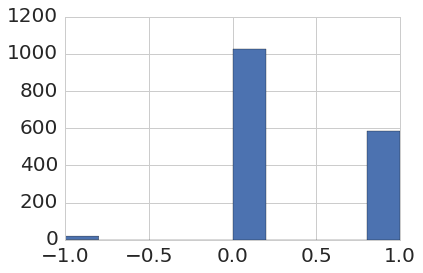

In [12]:
taipale_ppi['ddg_exp'].hist()

In [13]:
display(taipale_ppi.head(2))
print(taipale_ppi.shape[0])

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Y2H_score_x,In_Rolland_et_al,refseq_base_id,refseq_mutation,refseq_mutation_pos,Y2H_score_y,ddg_exp
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,BHLHE40,8553,0,1,NP_001079,A129T,129.0,1,1
1,Non-disease variant,AANAT,15,15_900207,NM_001088:c.8C>T,NP_001079:p.T3M,BHLHE40,8553,1,1,NP_001079,T3M,3.0,1,0


1633


## taipale_gpca

In [14]:
display(mmc3_table2_df.head(2))
print(mmc3_table2_df.shape[0])

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Interaction_category,GPCA_score1,GPCA_score2,GPCA_average_score,refseq_base_id,refseq_mutation,refseq_mutation_pos
0,Wild-type,AANAT,15,15_0,NaN,NaN,MDFI,4188,Y2H_positive,4.040826,4.698746,4.369786,NaN,NaN,NaN
1,Wild-type,AANAT,15,15_0,NaN,NaN,BHLHE40,8553,Y2H_positive,-1.458909,-1.131614,-1.295262,NaN,NaN,NaN


858


In [15]:
mmc3_table2_df_wt = mmc3_table2_df[mmc3_table2_df['Category'] == 'Wild-type']
mmc3_table2_df_mut = mmc3_table2_df[mmc3_table2_df['Category'] != 'Wild-type']

In [16]:
mmc3_table2_df_mut.shape[0]

676

In [17]:
taipale_gpca = (
    mmc3_table2_df_mut
    .merge(
        mmc3_table2_df_wt
        [['Symbol', 'Entrez_Gene_ID', 'Interactor_symbol', 'Interactor_Gene_ID', 'GPCA_average_score']],
        on=['Symbol', 'Entrez_Gene_ID', 'Interactor_symbol', 'Interactor_Gene_ID'])
)

In [18]:
taipale_gpca.shape

(492, 16)

In [19]:
taipale_gpca.head(2)

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Interaction_category,GPCA_score1,GPCA_score2,GPCA_average_score_x,refseq_base_id,refseq_mutation,refseq_mutation_pos,GPCA_average_score_y
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,MDFI,4188,Y2H_positive,3.776225,4.319209,4.047717,NP_001079,A129T,129.0,4.369786
1,Disease mutation,ACTB,60,60_12760,NM_001101:c.547C>T,NP_001092:p.R183W,ACTB,60,Y2H_positive,4.029925,5.021377,4.525651,NP_001092,R183W,183.0,2.902637


In [20]:
taipale_gpca['ddg_exp'] = taipale_gpca['GPCA_average_score_y'] - taipale_gpca['GPCA_average_score_x']

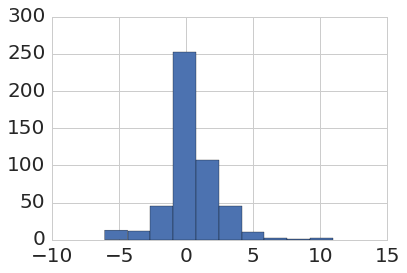

In [21]:
taipale_gpca['ddg_exp'].hist()

In [22]:
taipale_gpca.shape

(492, 17)

## taipale_edgotype

In [23]:
display(mmc3_table3_df.head(2))
print(mmc3_table3_df.shape[0])

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Edgotype_class,refseq_base_id,refseq_mutation,refseq_mutation_pos
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,Edgetic,NP_001079,A129T,129
1,Non-disease variant,AANAT,15,15_900207,NM_001088:c.8C>T,NP_001079:p.T3M,Quasi-wild-type,NP_001079,T3M,3


527


In [24]:
Counter(mmc3_table3_df['Edgotype_class'])

Counter({'Edgetic': 64,
         'Gain-and-loss-of-interaction': 3,
         'Gain-of-interaction': 10,
         'Perturbed-degree-1': 66,
         'Quasi-null': 53,
         'Quasi-wild-type': 127,
         'Unperturbed-degree-1': 204})

In [25]:
taipale_edgotype = mmc3_table3_df.copy()

## Summary

In [26]:
display(taipale_ppi.head(2))
print(taipale_ppi.shape[0])

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Y2H_score_x,In_Rolland_et_al,refseq_base_id,refseq_mutation,refseq_mutation_pos,Y2H_score_y,ddg_exp
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,BHLHE40,8553,0,1,NP_001079,A129T,129.0,1,1
1,Non-disease variant,AANAT,15,15_900207,NM_001088:c.8C>T,NP_001079:p.T3M,BHLHE40,8553,1,1,NP_001079,T3M,3.0,1,0


1633


In [27]:
display(taipale_gpca.head(2))
print(taipale_gpca.shape[0])

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Interaction_category,GPCA_score1,GPCA_score2,GPCA_average_score_x,refseq_base_id,refseq_mutation,refseq_mutation_pos,GPCA_average_score_y,ddg_exp
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,MDFI,4188,Y2H_positive,3.776225,4.319209,4.047717,NP_001079,A129T,129.0,4.369786,0.322069
1,Disease mutation,ACTB,60,60_12760,NM_001101:c.547C>T,NP_001092:p.R183W,ACTB,60,Y2H_positive,4.029925,5.021377,4.525651,NP_001092,R183W,183.0,2.902637,-1.623014


492


In [28]:
# Combine PPI and GPCA
df = (
    taipale_ppi
    .merge(taipale_gpca, on=['Symbol', 'Interactor_symbol', 'Mutation_RefSeq_AA'])  
)

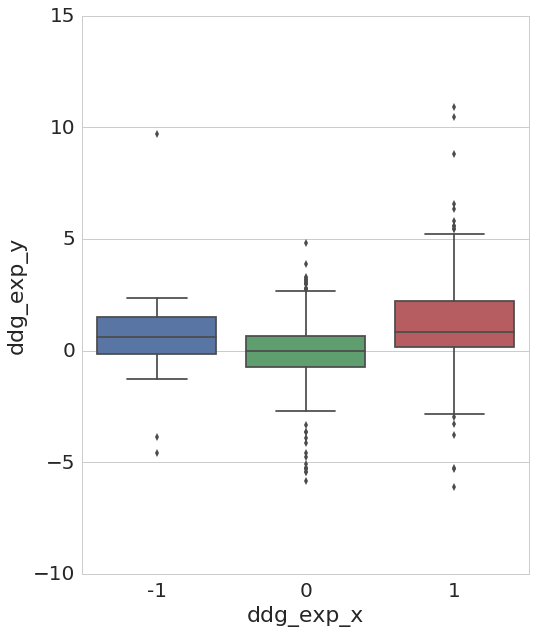

In [29]:
fg, ax = plt.subplots(figsize=(8,10))
sns.boxplot(x=df['ddg_exp_x'], y=df['ddg_exp_y'])

In [30]:
taipale_ppi_bak_1 = taipale_ppi.copy()
taipale_gpca_bak_1 = taipale_gpca.copy()
taipale_edgotype_bak_1 = taipale_edgotype.copy()

# Map to UniProt

In [31]:
taipale_ppi = taipale_ppi_bak_1.copy()
taipale_gpca = taipale_gpca_bak_1.copy()
taipale_edgotype = taipale_edgotype_bak_1.copy()

## Construct RefSeq / UniProt maps

In [32]:
# Create disctionaries for converting gene symbol to refseq / uniprot id
# (`gene_id_to_uniprot` only works for the partner UniProt ID!)
gene_symbol_to_refseq_1, gene_id_to_uniprot_1 = local.get_conversion_tables(taipale_ppi)
gene_symbol_to_refseq_2, gene_id_to_uniprot_2 = local.get_conversion_tables(taipale_gpca)

gene_symbol_to_refseq = pd.concat(
    [gene_symbol_to_refseq_1, gene_symbol_to_refseq_2],
    ignore_index=True).drop_duplicates()
gene_id_to_uniprot = pd.concat(
    [gene_id_to_uniprot_1, gene_id_to_uniprot_2],
    ignore_index=True).drop_duplicates()

print('Gene ID to RefSeq')
display(gene_symbol_to_refseq.head())
print(gene_symbol_to_refseq.shape[0])

print('\nGene ID to UniProt')
display(gene_id_to_uniprot.head())
print(gene_id_to_uniprot.shape[0])

Gene ID to RefSeq


,Symbol,refseq_base
0,AANAT,NP_001079
1,ACTB,NP_001092
2,ACTG1,NP_001605
3,ACTN2,NP_001094
4,ACTN4,NP_004915


223

Gene ID to UniProt


,identifier_id,uniprot_id
0,10016,O75340
1,10016,Q53FC3
2,100288797,Q8WW34
3,10062,B4DXU5
4,10062,F1D8N1


890


## Apply RefSeq / UniProt maps

In [33]:
# Covert gene symbol to refseq id (does not work for some partner proteins where we have never seen the refseq id.)
display(HTML('<h3>taipale_ppi:'))
taipale_ppi = local.convert_interacting_partner(taipale_ppi, gene_symbol_to_refseq, gene_id_to_uniprot)
display(HTML('<h3>taipale_gpca:'))
taipale_gpca = local.convert_interacting_partner(taipale_gpca, gene_symbol_to_refseq, gene_id_to_uniprot)

All rows:                                                   (2379, 17)
Unique interfaces / mutations:                              (1633, 3) <--
Unique interfaces / mutations mapped to uniprot:            (1633, 3)
Unique interfaces / mutations mapped to uniprot and refseq: (1633, 3)


All rows:                                                   (2364, 17)
Unique interfaces / mutations:                              (1633, 3) <--
Unique interfaces / mutations mapped to uniprot:            (1633, 3)
Unique interfaces / mutations mapped to uniprot and refseq: (1633, 3)


,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Y2H_score_x,In_Rolland_et_al,refseq_base_id,refseq_mutation,refseq_mutation_pos,Y2H_score_y,ddg_exp,refseq_base_id_1,uniprot_id_2
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,BHLHE40,8553,0,1,NP_001079,A129T,129.0,1,1,NP_001079,O14503
1,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,BHLHE40,8553,0,1,NP_001079,A129T,129.0,1,1,NP_001079,Q6IB83
2,Non-disease variant,AANAT,15,15_900207,NM_001088:c.8C>T,NP_001079:p.T3M,BHLHE40,8553,1,1,NP_001079,T3M,3.0,1,0,NP_001079,O14503
3,Non-disease variant,AANAT,15,15_900207,NM_001088:c.8C>T,NP_001079:p.T3M,BHLHE40,8553,1,1,NP_001079,T3M,3.0,1,0,NP_001079,Q6IB83


All rows:                                                   (747, 19)
Unique interfaces / mutations:                              (492, 3) <--
Unique interfaces / mutations mapped to uniprot:            (492, 3)
Unique interfaces / mutations mapped to uniprot and refseq: (492, 3)


All rows:                                                   (747, 19)
Unique interfaces / mutations:                              (492, 3) <--
Unique interfaces / mutations mapped to uniprot:            (492, 3)
Unique interfaces / mutations mapped to uniprot and refseq: (492, 3)


,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Interaction_category,GPCA_score1,GPCA_score2,GPCA_average_score_x,refseq_base_id,refseq_mutation,refseq_mutation_pos,GPCA_average_score_y,ddg_exp,refseq_base_id_1,uniprot_id_2
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,MDFI,4188,Y2H_positive,3.776225,4.319209,4.047717,NP_001079,A129T,129.0,4.369786,0.322069,NP_001079,B1AKB6
1,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,MDFI,4188,Y2H_positive,3.776225,4.319209,4.047717,NP_001079,A129T,129.0,4.369786,0.322069,NP_001079,Q99750
2,Disease mutation,ACTB,60,60_12760,NM_001101:c.547C>T,NP_001092:p.R183W,ACTB,60,Y2H_positive,4.029925,5.021377,4.525651,NP_001092,R183W,183.0,2.902637,-1.623014,NP_001092,B3KWQ3
3,Disease mutation,ACTB,60,60_12760,NM_001101:c.547C>T,NP_001092:p.R183W,ACTB,60,Y2H_positive,4.029925,5.021377,4.525651,NP_001092,R183W,183.0,2.902637,-1.623014,NP_001092,P60709


## Convert to UniProt mutations

### taipale_uniprot_df

In [34]:
# Create a temporary table in the database (`staging`.`taipale_mmc3`)
data_to_upload = (
    pd.concat(
        [taipale_ppi[['refseq_base_id', 'refseq_mutation', 'refseq_mutation_pos']],
         taipale_gpca[['refseq_base_id', 'refseq_mutation', 'refseq_mutation_pos']]],
        ignore_index=True
    )
    .dropna()
    .drop_duplicates()
)

In [35]:
# Print stats
print2(
    "Mutations from 'taipale_ppi':", 
    taipale_ppi[['refseq_base_id', 'refseq_mutation', 'refseq_mutation_pos']].drop_duplicates().shape)
print2(
    "Mutations from 'taipale_gpca':",
    taipale_gpca[['refseq_base_id', 'refseq_mutation', 'refseq_mutation_pos']].drop_duplicates().shape)
print2(
    "Combined:", 
    data_to_upload.shape)

Mutations from 'taipale_ppi':                               (527, 3)
Mutations from 'taipale_gpca':                              (110, 3)
Combined:                                                   (527, 3)


In [36]:
data_to_upload.to_sql('taipale', db_remote.engine, schema='staging', if_exists='replace')

In [37]:
# Convert RefSeq ID and position to UniProt (canonical) ID and position
sql_query = """
SELECT
-- RefSeq
m.index,
m.refseq_base_id,
m.refseq_mutation,
m.refseq_mutation_pos,
ux.active refseq_active,
ucuc.uniparc_sequence refseq_sequence,

-- UniProt
uxc.id uniprot_id,
FIND_IN_SET(refseq_mutation_pos, a2b) uniprot_mutation_pos,
uxc.active uniprot_active,
# Don't use UniParc sequence because it might be different version than ELASPIC
us.uniprot_sequence uniprot_sequence

FROM staging.taipale m
JOIN uniparc_human.uniparc_xref ux ON (ux.type = 'RefSeq' AND ux.id = m.refseq_base_id)
JOIN uniparc_human.uniparc2uniparc_canonical_mapping ucuc USING (uniparc_id)
JOIN uniparc_human.uniparc_xref uxc ON (uxc.uniparc_id = ucuc.uniparc_canonical_id AND \
                                        uxc.type = 'UniProtKB/Swiss-Prot')
JOIN uniprot_kb.uniprot_sequence us ON (us.uniprot_id = uxc.id);
"""

In [38]:
cache_file = op.join(NOTEBOOK_NAME, 'taipale_uniprot_df.pkl')
if op.isfile(cache_file):
    taipale_uniprot_df = pd.read_pickle(cache_file)
else:
    taipale_uniprot_df = pd.read_sql_query(sql_query, db_remote.engine)
    taipale_uniprot_df.to_pickle(cache_file)

In [39]:
taipale_uniprot_df.head(2)

,index,refseq_base_id,refseq_mutation,refseq_mutation_pos,refseq_active,refseq_sequence,uniprot_id,uniprot_mutation_pos,uniprot_active,uniprot_sequence
0,0,NP_001079,A129T,129.0,N,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...
1,0,NP_001079,A129T,129.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...


### taipale_uniprot_df_good

In [40]:
display(taipale_uniprot_df.head())
print(taipale_uniprot_df.shape)

,index,refseq_base_id,refseq_mutation,refseq_mutation_pos,refseq_active,refseq_sequence,uniprot_id,uniprot_mutation_pos,uniprot_active,uniprot_sequence
0,0,NP_001079,A129T,129.0,N,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...
1,0,NP_001079,A129T,129.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...
2,2,NP_001079,T3M,3.0,N,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,3,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...
3,2,NP_001079,T3M,3.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,3,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...
4,8,NP_001092,R183W,183.0,N,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,P60709,183,Y,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...


(1008, 10)


In [41]:
taipale_uniprot_df['uniprot_mutation'] = (
    taipale_uniprot_df[['refseq_mutation', 'uniprot_mutation_pos']]
    .apply(lambda x: x[0][0] + str(x[1]) + x[0][-1], axis=1)
)

In [42]:
taipale_uniprot_df['refseq_mutation_matches_sequence'] = (
    taipale_uniprot_df[['refseq_mutation', 'refseq_sequence']]
    .apply(lambda x: ascommon.sequence_tools.mutation_matches_sequence(*x), axis=1)
)

In [43]:
taipale_uniprot_df['uniprot_mutation_matches_sequence'] = (
    taipale_uniprot_df[['uniprot_mutation', 'uniprot_sequence']]
    .apply(lambda x: ascommon.sequence_tools.mutation_matches_sequence(*x), axis=1)
)

In [44]:
display(taipale_uniprot_df.head())
print(taipale_uniprot_df.shape)

,index,refseq_base_id,refseq_mutation,refseq_mutation_pos,refseq_active,refseq_sequence,uniprot_id,uniprot_mutation_pos,uniprot_active,uniprot_sequence,uniprot_mutation,refseq_mutation_matches_sequence,uniprot_mutation_matches_sequence
0,0,NP_001079,A129T,129.0,N,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,A129T,True,True
1,0,NP_001079,A129T,129.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,A129T,True,True
2,2,NP_001079,T3M,3.0,N,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,3,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,T3M,True,True
3,2,NP_001079,T3M,3.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,3,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,T3M,True,True
4,8,NP_001092,R183W,183.0,N,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,P60709,183,Y,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,R183W,True,True


(1008, 13)


In [45]:
# All
df = taipale_uniprot_df
print2("Not 'uniprot_mutation_pos':", (df['uniprot_mutation_pos'] == 0).sum())
print2("Not 'uniprot_mutation_matches_sequence':", (~df['refseq_mutation_matches_sequence']).sum())
print2("Not 'refseq_mutation_matches_sequence':", (~df['refseq_mutation_matches_sequence']).sum())
print2("Not 'uniprot_active':", (df['uniprot_active'] == 'N').sum())
print2("Not 'refseq_active':", (df['refseq_active'] == 'N').sum())
print(df.shape[0], df['index'].drop_duplicates().shape[0])

Not 'uniprot_mutation_pos':                                 10
Not 'uniprot_mutation_matches_sequence':                    15
Not 'refseq_mutation_matches_sequence':                     15
Not 'uniprot_active':                                       40
Not 'refseq_active':                                        459
1008 526


In [46]:
# Select the best mapping for each mutation
taipale_uniprot_df_select = (
    taipale_uniprot_df
    .sort_values([
        'uniprot_mutation_pos', 'uniprot_mutation_matches_sequence', 'refseq_mutation_matches_sequence',
        'uniprot_active', 'refseq_active'], ascending=False)
    .drop_duplicates(['refseq_base_id', 'refseq_mutation', 'uniprot_id', 'uniprot_mutation'])
    .sort_values(['uniprot_id', 'uniprot_mutation_pos', 'uniprot_mutation'], ascending=True)
)

In [47]:
df = taipale_uniprot_df_select
print2("Not 'uniprot_mutation_pos':", (df['uniprot_mutation_pos'] == 0).sum())
print2("Not 'uniprot_mutation_matches_sequence':", (~df['refseq_mutation_matches_sequence']).sum())
print2("Not 'refseq_mutation_matches_sequence':", (~df['refseq_mutation_matches_sequence']).sum())
print2("Not 'uniprot_active':", (df['uniprot_active'] == 'N').sum())
print2("Not 'refseq_active':", (df['refseq_active'] == 'N').sum())
print(df.shape[0], df['index'].drop_duplicates().shape[0])

Not 'uniprot_mutation_pos':                                 6
Not 'uniprot_mutation_matches_sequence':                    13
Not 'refseq_mutation_matches_sequence':                     13
Not 'uniprot_active':                                       0
Not 'refseq_active':                                        13
542 526


In [48]:
# Select valid mappings
taipale_uniprot_df_good = (
    taipale_uniprot_df_select[
        (taipale_uniprot_df_select['uniprot_mutation_pos'] != 0) &
        (df['refseq_mutation_matches_sequence']) &
        (df['refseq_mutation_matches_sequence'])
    ]
)

In [49]:
df = taipale_uniprot_df_good
print2("Not 'uniprot_mutation_pos':", (df['uniprot_mutation_pos'] == 0).sum())
print2("Not 'uniprot_mutation_matches_sequence':", (~df['refseq_mutation_matches_sequence']).sum())
print2("Not 'refseq_mutation_matches_sequence':", (~df['refseq_mutation_matches_sequence']).sum())
print2("Not 'uniprot_active':", (df['uniprot_active'] == 'N').sum())
print2("Not 'refseq_active':", (df['refseq_active'] == 'N').sum())
print(df.shape[0], df['index'].drop_duplicates().shape[0])

Not 'uniprot_mutation_pos':                                 0
Not 'uniprot_mutation_matches_sequence':                    0
Not 'refseq_mutation_matches_sequence':                     0
Not 'uniprot_active':                                       0
Not 'refseq_active':                                        9
525 522


In [50]:
taipale_uniprot_df_good.to_pickle(op.join(NOTEBOOK_NAME, 'taipale_uniprot_df_good.pkl'))

In [51]:
taipale_uniprot_df_good_bak = taipale_uniprot_df_good.copy()

### Merge back

In [52]:
taipale_uniprot_df_good_bak = pd.read_pickle(op.join(NOTEBOOK_NAME, 'taipale_uniprot_df_good.pkl'))

In [53]:
taipale_uniprot_df = (
    taipale_uniprot_df_good_bak
    .drop('index', axis=1)
)

In [54]:
taipale_ppi = (
    taipale_ppi.merge(
        taipale_uniprot_df, 
        on=['refseq_base_id', 'refseq_mutation', 'refseq_mutation_pos'],
        how='left'))

In [55]:
taipale_gpca = (
    taipale_gpca.merge(
        taipale_uniprot_df, 
        on=['refseq_base_id', 'refseq_mutation', 'refseq_mutation_pos'],
        how='left'))

In [56]:
taipale_edgotype = (
    taipale_edgotype.merge(
        taipale_uniprot_df, 
        on=['refseq_base_id', 'refseq_mutation', 'refseq_mutation_pos'],
        how='left'))

In [57]:
# Make a copy for future reference
taipale_ppi_2_bak = taipale_ppi.copy()
taipale_gpca_2_bak = taipale_gpca.copy()
taipale_edgotype_2_bak = taipale_edgotype.copy()

In [58]:
# Save for future reference
taipale_ppi_2_bak.to_pickle(op.join(NOTEBOOK_NAME, 'taipale_ppi_2_bak.pkl'))
taipale_gpca_2_bak.to_pickle(op.join(NOTEBOOK_NAME, 'taipale_gpca_2_bak.pkl'))
taipale_edgotype_2_bak.to_pickle(op.join(NOTEBOOK_NAME, 'taipale_edgotype_2_bak.pkl'))

# Save to database

In [75]:
# Save a copy for future reference
taipale_ppi = pd.read_pickle(op.join(NOTEBOOK_NAME, 'taipale_ppi_2_bak.pkl'))
taipale_gpca = pd.read_pickle(op.join(NOTEBOOK_NAME, 'taipale_gpca_2_bak.pkl'))
taipale_edgotype = pd.read_pickle(op.join(NOTEBOOK_NAME, 'taipale_edgotype_2_bak.pkl'))

## taipale_ppi

In [76]:
display(taipale_ppi.head(2))
print2("Number or rows:", taipale_ppi.shape[0])
print2(
    "Unique refseq mutations:",
    taipale_ppi.drop_duplicates(['refseq_base_id', 'refseq_mutation']).shape)
print2(
    "Unique uniprot mutations:",
    taipale_ppi.drop_duplicates(['uniprot_id', 'uniprot_mutation']).shape)
print2(
    "Unique refseq interface mutations:",
    taipale_ppi.drop_duplicates(['refseq_base_id', 'refseq_mutation', 'Interactor_Gene_ID']).shape)
print2(
    "Unique uniprot interface mutations:",
    taipale_ppi.drop_duplicates(['uniprot_id', 'uniprot_mutation', 'uniprot_id_2']).shape)

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Y2H_score_x,In_Rolland_et_al,refseq_base_id,refseq_mutation,refseq_mutation_pos,Y2H_score_y,ddg_exp,refseq_base_id_1,uniprot_id_2,refseq_active,refseq_sequence,uniprot_id,uniprot_mutation_pos,uniprot_active,uniprot_sequence,uniprot_mutation,refseq_mutation_matches_sequence,uniprot_mutation_matches_sequence
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,BHLHE40,8553,0,1,NP_001079,A129T,129.0,1,1,NP_001079,O14503,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,A129T,True,True
1,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,BHLHE40,8553,0,1,NP_001079,A129T,129.0,1,1,NP_001079,Q6IB83,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,A129T,True,True


Number or rows:                                             2367
Unique refseq mutations:                                    (527, 26)
Unique uniprot mutations:                                   (526, 26)
Unique refseq interface mutations:                          (1633, 26)
Unique uniprot interface mutations:                         (2366, 26)


In [77]:
df = (
    taipale_ppi
    [['uniprot_id', 'uniprot_id_2', 'uniprot_mutation', 'ddg_exp']]
    .rename(columns={'uniprot_id_2': 'partner_uniprot_id'})
    .dropna()
)

In [78]:
print(df.shape[0])

2348


In [79]:
t = db.import_df(
    df,
    'taipale_ppi',
    use_temp_file=False,
)

In [80]:
db.create_indexes(
    t.name,
    [(['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation'], True),
     (['partner_uniprot_id', 'uniprot_id', 'uniprot_mutation'], True)]
)

In [81]:
db.add_idx_column(t.name)

2348

## taipale_gpca

In [82]:
display(taipale_gpca.head(2))
print2("Number or rows:", taipale_gpca.shape[0])
print2(
    "Unique refseq mutations:",
    taipale_gpca.drop_duplicates(['refseq_base_id', 'refseq_mutation']).shape)
print2(
    "Unique uniprot mutations:",
    taipale_gpca.drop_duplicates(['uniprot_id', 'uniprot_mutation']).shape)
print2(
    "Unique refseq interface mutations:",
    taipale_gpca.drop_duplicates(['refseq_base_id', 'refseq_mutation', 'Interactor_Gene_ID']).shape)
print2(
    "Unique uniprot interface mutations:",
    taipale_gpca.drop_duplicates(['uniprot_id', 'uniprot_mutation', 'uniprot_id_2']).shape)

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Interactor_symbol,Interactor_Gene_ID,Interaction_category,GPCA_score1,GPCA_score2,GPCA_average_score_x,refseq_base_id,refseq_mutation,refseq_mutation_pos,GPCA_average_score_y,ddg_exp,refseq_base_id_1,uniprot_id_2,refseq_active,refseq_sequence,uniprot_id,uniprot_mutation_pos,uniprot_active,uniprot_sequence,uniprot_mutation,refseq_mutation_matches_sequence,uniprot_mutation_matches_sequence
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,MDFI,4188,Y2H_positive,3.776225,4.319209,4.047717,NP_001079,A129T,129.0,4.369786,0.322069,NP_001079,B1AKB6,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,A129T,True,True
1,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,MDFI,4188,Y2H_positive,3.776225,4.319209,4.047717,NP_001079,A129T,129.0,4.369786,0.322069,NP_001079,Q99750,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,A129T,True,True


Number or rows:                                             747
Unique refseq mutations:                                    (110, 28)
Unique uniprot mutations:                                   (110, 28)
Unique refseq interface mutations:                          (492, 28)
Unique uniprot interface mutations:                         (747, 28)


In [83]:
df = (
    taipale_gpca
    [['uniprot_id', 'uniprot_id_2', 'uniprot_mutation', 'ddg_exp']]
    .rename(columns={'uniprot_id_2': 'partner_uniprot_id'})
    .dropna()
)

In [84]:
print(df.shape[0])

742


In [85]:
t = db.import_df(
    df,
    'taipale_gpca',
    use_temp_file=False,
)

In [86]:
db.create_indexes(
    t.name,
    [(['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation'], True),
     (['partner_uniprot_id', 'uniprot_id', 'uniprot_mutation'], True)]
)

In [87]:
db.add_idx_column(t.name)

742

## taipale_edgotype

In [88]:
display(taipale_edgotype.head(2))
print2("Number or rows:", taipale_edgotype.shape[0])
print2(
    "Unique refseq mutations:",
    taipale_edgotype.drop_duplicates(['refseq_base_id', 'refseq_mutation']).shape)
print2(
    "Unique uniprot mutations:",
    taipale_edgotype.drop_duplicates(['uniprot_id', 'uniprot_mutation']).shape)

,Category,Symbol,Entrez_Gene_ID,Allele_ID,Mutation_RefSeq_NT,Mutation_RefSeq_AA,Edgotype_class,refseq_base_id,refseq_mutation,refseq_mutation_pos,refseq_active,refseq_sequence,uniprot_id,uniprot_mutation_pos,uniprot_active,uniprot_sequence,uniprot_mutation,refseq_mutation_matches_sequence,uniprot_mutation_matches_sequence
0,Disease mutation,AANAT,15,15_22963,NM_001088:c.385G>A,NP_001079:p.A129T,Edgetic,NP_001079,A129T,129,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,129.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,A129T,True,True
1,Non-disease variant,AANAT,15,15_900207,NM_001088:c.8C>T,NP_001079:p.T3M,Quasi-wild-type,NP_001079,T3M,3,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,Q16613,3.0,Y,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...,T3M,True,True


Number or rows:                                             530
Unique refseq mutations:                                    (527, 19)
Unique uniprot mutations:                                   (526, 19)


In [89]:
df = (
    taipale_edgotype
    [['uniprot_id', 'uniprot_mutation', 'Edgotype_class']]
    .rename(columns={'Edgotype_class': 'edgotype_class'})
    .dropna()
)

In [90]:
print(df.shape[0])

525


In [91]:
t = db.import_df(
    df,
    'taipale_edgotype',
    use_temp_file=False,
)

In [92]:
db.create_indexes(
    t.name,
    [(['uniprot_id', 'uniprot_mutation'], True)],
)

In [93]:
db.add_idx_column(t.name)

525